In [1]:
import os
import rasterio
from rasterio.windows import Window
from rasterio.transform import Affine
import math
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

Overlay the heightmap and NDVI into a single tif, such that band_1 = heightmap and band_2 = NDVI. 

In [ ]:
def overlay_heightmap_ndvi(heightmap_path, ndvi_path, output_path):
    # Open the heightmap
    with rasterio.open(heightmap_path) as src_height:
        heightmap = src_height.read(1)
        profile = src_height.profile.copy()
    
    # Open the NDVI
    with rasterio.open(ndvi_path) as src_ndvi:
        ndvi = src_ndvi.read(1)
        
        # Check that they match in shape
        if heightmap.shape != ndvi.shape:
            raise ValueError("Heightmap and NDVI rasters do not have matching dimensions.")
    
    # Stack the two arrays together
    stacked = np.stack([heightmap, ndvi])
    
    # Update profile for 2 bands
    profile.update(
        count=2,
        dtype=rasterio.float32,  # assuming you want floats; change if needed
        compress='lzw'
    )
    
    # Write the stacked raster
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(stacked)
    
    print(f"Overlay raster saved to {output_path}")

heightmap_tif = "I:/terrain_generation_project/ca2015_la_dem_J1170593.tif"
ndvi_tif = "I:/terrain_generation_project/NAIP_processed/naip_ndvi_1_8.tif"
output_file = "dem_ndvi_1-8.tif"

overlay_heightmap_ndvi(heightmap_tif, ndvi_tif, output_file)

Split large geo tif into tiles while retaining the geographic metadata

In [5]:
def tile_geotiff(input_path, output_dir, tile_size=512):
    # Open the source GeoTIFF
    with rasterio.open(input_path) as src:
        width = src.width
        height = src.height
        profile = src.profile
        transform = src.transform

        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

        # Calculate number of tiles in x and y direction
        n_cols = math.ceil(width / tile_size)
        n_rows = math.ceil(height / tile_size)

        print(f"Image size: {width}x{height}")
        print(f"Tiling into {n_cols} columns and {n_rows} rows of {tile_size}x{tile_size} tiles...")

        total_tiles = n_rows * n_cols
        with tqdm(total=total_tiles, desc="Tiling") as pbar:
            for i in range(n_rows):
                for j in range(n_cols):
                    x_off = j * tile_size
                    y_off = i * tile_size
                    win_width = min(tile_size, width - x_off)
                    win_height = min(tile_size, height - y_off)

                    window = Window(x_off, y_off, win_width, win_height)
                    transform_tile = src.window_transform(window)

                    # Read the window from the source
                    tile_data = src.read(window=window)

                    # Update metadata for the tile
                    tile_profile = profile.copy()
                    tile_profile.update({
                        'height': win_height,
                        'width': win_width,
                        'transform': transform_tile
                    })

                    tile_filename = os.path.join(output_dir, f"tile_{i}_{j}.tif")

                    # Write the tile
                    with rasterio.open(tile_filename, 'w', **tile_profile) as dst:
                        dst.write(tile_data)

                    pbar.update(1)

In [6]:
input_tif = "data/ca2015_la_dem_J1170593.tif"
output_folder = "data/tiles"
tile_geotiff(input_tif, output_folder)

Image size: 15888x11091
Tiling into 32 columns and 22 rows of 512x512 tiles...


Tiling: 100%|██████████| 704/704 [00:29<00:00, 23.98it/s]


Display test image

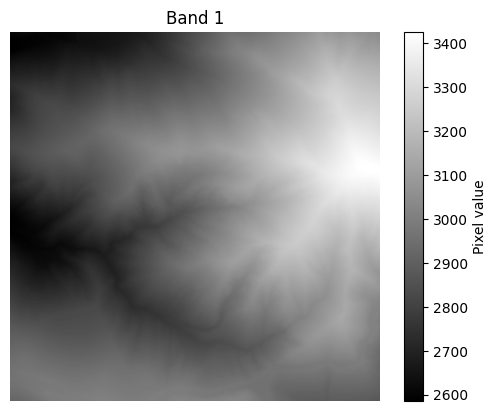

In [11]:
image_path = "data/tiles/tile_0_0.tif"

# Load the single-band TIFF
with rasterio.open(image_path) as src:
    band1 = src.read(1)

# Display it
plt.imshow(band1, cmap='gray')
plt.colorbar(label='Pixel value')
plt.axis('off')
plt.title("Band 1")
plt.show()